# Have the Conservatives Moved Left?

In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [2]:
dataset_name = "W16_comb"
df_list = [ "BES_Panel", ]

In [3]:
%matplotlib inline

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re

sns.set();
sns.set_palette("colorblind")

from IPython.display import display, display_html, HTML
plt.rcParams["axes.grid"] = False

import Jupyter_module_loader
from utility import *
import gaussian_kde

import warnings
warnings.filterwarnings('ignore')

import holoviews as hv
from holoviews import opts

encoding = "ISO-8859-1"

In [4]:
# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
# %matplotlib inline
(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()

global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
    else:
        globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
# (var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

# get full set of inferred "cross wave" auth-lib/left-right values and ages
pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_values"+".csv")
pan_dataset_ages = pd.read_csv( BES_small_data_files + "pan_dataset_ages"+".csv" )

In [5]:
def weighted_mean(x, **kws):
    val, weight = map(np.asarray, zip(*x))
    return (val * weight).sum() / weight.sum()

In [6]:
max_wave = int(re.match("W(\d+)_",dataset_name).groups()[0])
num_to_wave = {x:"W"+str(x) for x in range(1,max_wave+1)}
wts_for_wave = { "W"+str(y):[x for x in BES_Panel.columns.sort_values(ascending=False) if re.match("wt_(new|full)_W"+str(y)+"$",x)][0] for y in range(1,max_wave+1) }
# wts_for_wave

In [7]:
df = pd.Series([re.match("(.*?)($|W\d+)",x).groups()[0] for x in BES_Panel.columns]).value_counts()
df

wt_new_               33
wt_full_              25
likeCon               16
likeLD                16
leftRight             16
                      ..
fatherCountryBorn      1
blameLeave_7           1
ukipLookAfterUnemp     1
profile_ethnicity      1
proposalHealth         1
Length: 1918, dtype: int64

In [8]:
# BES_Panel["goodTimePurchaseW8"]

In [9]:
drop_list = ["starttime","endtime","bestOnMII","mii","wt_full_","wt_new_","pano","pcon"]
df[df==10].drop(drop_list,errors='ignore').sort_index()

age                  10
dutyToVote2          10
euID                 10
euID1                10
euID2                10
euID3                10
euID4                10
euID6                10
euID7                10
europeanness         10
gor                  10
headHouseholdPast    10
immigCon             10
immigGreen           10
immigLD              10
immigLab             10
immigPC              10
immigSNP             10
immigSelf            10
immigUKIP            10
likeCorbyn           10
referendumSettled    10
snpUnited            10
dtype: int64

In [10]:
np.unique([x.split("W")[0] for x in search(BES_Panel,".*Con(W|$)",case_sensitive=True).index])

array(['EUContactLeaveCon', 'EUContactRemainCon', 'EUIntegrationCon',
       'achieveReduceImmigCon', 'brexitCon', 'certaintyEUCon',
       'certaintyRedistCon', 'eesEUIntegrationCon', 'handleMIICon',
       'immigCon', 'leaveVoteUKIPCon', 'likeCon', 'lrCon',
       'majorityPartyCon', 'mapCon', 'natSecurityCon',
       'noChanceCoalitionCon', 'partyContactCon', 'partySiteCon',
       'ptvCon', 'redistCon', 'responsibleCostLiveCon',
       'responsibleEducationCon', 'scotCon', 'socialDistCon',
       'successReduceInequalityCon', 'taxSpendCon', 'tryReduceImmigCon',
       'tryReduceInequalityCon', 'welshCon', 'winConstituencyCon'],
      dtype='<U26')

In [11]:
# np.unique([x.split("W")[0] for x in search(BES_Panel,".*Con",case_sensitive=True).index])

In [12]:
# StrongLeader W10W11W14W15W16
# like<Leader>/<party>
# ptv<party>
# partyId(/Squeeze/Strength),generalElectionVote,bestOnMII,leftRight
# <party>United
# EUIntegration<party>

# 14
# britishness,scottishness,welshness,
# econGenRetro, econPersonalRetro
# turnoutUKGeneral, education

# 13
# partyContact
# mii_cat, LRAL_mii_cat, small_mii_cat
# changeEconomy, goodTimePurchase, polAttention, satDem(Eng/Scot/UK/Wales), riskPoverty, riskUnemployment
# scotReferendumIntention
# lr<party>, redist<party>

# 12
# change(Education/NHS)
# efficacy(NotUnderstand/PolCare/TooMuchEffort/Understand)
# immig(Cultural/Economy)
# trustMPs

# 11
# pid<features>
# change(CostLive/Crime/Immig)
# approve(ScotGovt/UKGovt/WelshGovt)


In [13]:
BES_Panel[search(BES_Panel,"endtime").index].min()

endtimeW1    2014-02-19 16:22:34.488
endtimeW2    2014-05-22 21:22:21.698
endtimeW3    1970-01-01 00:00:00.000
endtimeW4    2015-03-04 18:26:51.695
endtimeW5    2015-03-30 08:53:36.930
endtimeW6    2015-05-08 15:12:46.173
endtimeW7    2016-04-14 10:32:41.766
endtimeW8    2016-05-06 14:19:31.887
endtimeW9    2016-06-24 16:31:52.996
endtimeW10   2016-11-24 09:14:31.890
endtimeW11   2017-04-24 07:40:07.341
endtimeW12   2017-05-05 09:34:36.706
endtimeW13   2017-06-09 16:02:51.901
endtimeW14   2018-05-04 11:11:49.794
endtimeW15   2019-03-11 15:23:47.838
endtimeW16   2019-05-24 09:01:28.620
dtype: datetime64[ns]

In [14]:
def time_series(var_name,title,subtract_var=False,retain_var=True,specific_dates=True,use_midpoints=True,col_name="party",dk_nums=[11,-1],dk_str="Don't know",max_y_size=10.0,min_waves_included=3):

    df=pd.DataFrame()
    df2 =pd.DataFrame()
    df_wts =pd.DataFrame()
    df_dates = pd.DataFrame()
    
    if subtract_var:
        title=title+"\n(where respondents place parties relative to their own preference set at 0.5)"


    wave_list = []
    redist_vars = pd.Series([re.match(var_name+"([a-zA-Z]*)($|W\d+)",x).groups()[0] for x in BES_Panel.columns if re.match("("+var_name+"[a-zA-Z]*)($|W\d+)",x)]).value_counts()
    redist_vars = redist_vars[redist_vars>=min_waves_included].index

    for subj in redist_vars:
        for wave in ["W"+str(x) for x in range(1,17)]:
            if var_name+subj+wave not in BES_Panel.columns:
                continue
            else:
                wave_list.append(wave)
            df[var_name+"num_"+subj+"_"+wave] = BES_Panel[var_name+subj+wave].cat.codes.replace(dk_nums,[np.nan for x in range(0,len(dk_nums))])/max_y_size
            df2[var_name+"dk_"+subj+"_"+wave] = BES_Panel[var_name+subj+wave]==dk_str
            df2[var_name+"dk_"+subj+"_"+wave][BES_Panel[var_name+subj+wave].isnull()] = np.nan
    for wave in pd.unique(wave_list):        
        df_wts["wt_"+wave] = BES_Panel[wts_for_wave[wave]]
        if use_midpoints:
            df_dates["dt_"+wave] = BES_Panel["midpoint"+wave]
        else:
            df_dates["dt_"+wave] = (BES_Panel["starttime"+wave]+(BES_Panel["endtime"+wave]-BES_Panel["starttime"+wave])/2).apply(lambda x:x.date())

    df_wts = df_wts[df.notnull().any(axis=1)]
    df = df[df.notnull().any(axis=1)]

    df2.columns = df2.columns.str.split('_', expand=True)
    df2 = df2.stack(dropna=False)\
                .reset_index()\
                .rename(columns={'level_1':"wave"})\
                .rename(columns={'level_0':"id"}) 

    df_wts.columns = df_wts.columns.str.split('_', expand=True)
    df_wts = df_wts.stack(dropna=False)\
                .reset_index()\
                .rename(columns={'level_1':"wave"})\
                .rename(columns={'level_0':"id"}) 

    df_dates.columns = df_dates.columns.str.split('_', expand=True)
    df_dates = df_dates.stack(dropna=False)\
                .reset_index()\
                .rename(columns={'level_1':"wave"})\
                .rename(columns={'level_0':"id"}) 

    df.columns = df.columns.str.split('_', expand=True)
    df = df.stack(dropna=False)\
            .reset_index()\
            .rename(columns={'level_1':"wave"})\
            .rename(columns={'level_0':"id"}) 

    df["wt"] = df_wts["wt"]

    df = df.loc[ df[[x for x in df.columns if var_name+"num" in x]].notnull().any(axis=1) ]
    df.loc[:,"wt"] = df.loc[:,"wt"].fillna(1.0).values
    temp_ind_name = "temp_index"

    if specific_dates:
        df["wave"] = df[["id","wave"]].merge(right=df_dates,
                 how="left",left_on=["id","wave"],right_on=["id","wave"])["dt"].values

    df[temp_ind_name] = list(zip(df["wave"],df["wt"]))
    df = df.set_index(temp_ind_name).drop(["id","wave","wt"],axis=1)

    df2["wt"] = df_wts["wt"]

    if subtract_var:
        if retain_var:
            focal_vars = [x for x in df.columns if (var_name+"num" in x) and (subtract_var not in x)]
            df[focal_vars] = df[focal_vars].apply(lambda x: x-df[(var_name+"num",  subtract_var)])+0.5
        else:
            focal_vars = [x for x in df.columns if var_name+"num" in x]
            df[focal_vars] = df[focal_vars].apply(lambda x: x-df[(var_name+"num",  subtract_var)])+0.5
            df.drop((var_name+"num",  subtract_var),axis=1,inplace=True)


    df2 = df2.loc[ df2[[x for x in df2.columns if var_name+"dk" in x]].notnull().any(axis=1) ]
    df2.loc[:,"wt"] = df2.loc[:,"wt"].fillna(1.0).values
    if specific_dates:
        df2["wave"] = df2[["id","wave"]].merge(right=df_dates,
                 how="left",left_on=["id","wave"],right_on=["id","wave"])["dt"].values

    temp_ind_name = "temp_index"
    df2[temp_ind_name] = list(zip(df2["wave"],df2["wt"]))
    df2 = df2.set_index(temp_ind_name).drop(["id","wave","wt"],axis=1)


    flat_df_num = df.stack().reset_index().rename(columns={'level_1':col_name})

    if specific_dates:
        flat_df_num["wave"] = flat_df_num[temp_ind_name].apply(lambda x:x[0])    
    else:
        flat_df_num["wave"] = flat_df_num[temp_ind_name].apply(lambda x:int(x[0].split("W")[1]))


    flat_df_num["wt"] = flat_df_num[temp_ind_name].apply(lambda x:x[1])
    flat_df_num.drop(temp_ind_name,axis=1,inplace=True)
    flat_df_num[col_name] = flat_df_num[col_name].astype('category')

    flat_df_num[var_name+"_wts"] = list(zip(flat_df_num[var_name+"num"],flat_df_num["wt"]))

    flat_df_dk = df2.stack().reset_index().rename(columns={'level_1':col_name,0:"dk"})
    if specific_dates:
        flat_df_dk["wave"] = flat_df_dk[temp_ind_name].apply(lambda x:x[0])    
    else:
        flat_df_dk["wave"] = flat_df_dk[temp_ind_name].apply(lambda x:int(x[0].split("W")[1]))

    flat_df_dk["wt"] = flat_df_dk[temp_ind_name].apply(lambda x:x[1])
    flat_df_dk.drop(temp_ind_name,axis=1,inplace=True)
    flat_df_dk[var_name+"dk"] = flat_df_dk[var_name+"dk"].astype('int')
    flat_df_dk = flat_df_dk.groupby(["wave",col_name]).apply(lambda x: (x["wt"]*x[var_name+"dk"]).sum()/x["wt"].sum() ).reset_index().rename(columns={0:"dk"})

    flat_df_num = flat_df_num.merge(right=flat_df_dk[[col_name,"wave","dk"]],how='left',left_on=[col_name,"wave"],right_on=[col_name,"wave"])
    if not specific_dates:
        flat_df_num["wave"] = flat_df_num["wave"].apply(lambda x: wave_to_date[x])
        flat_df_num["wave"] = pd.to_datetime(flat_df_num["wave"] , format="%b-%y")

    return flat_df_num

In [15]:
# flat_df_num = time_series(var_name, title, min_waves_included=3)

In [16]:
# BES_Panel["endtime"+wave]+
# ((BES_Panel["endtime"+wave]-BES_Panel["starttime"+wave])/2)

In [17]:
# BES_Panel["midpoint"+wave]

In [18]:


# fix order of redist cats
redist_cats = BES_Panel["redistConW16"].cat.categories

BES_Panel[match(BES_Panel,"redist").index] = \
    BES_Panel[match(BES_Panel,"redist").index]\
        .apply(lambda x: x.cat.reorder_categories(redist_cats))

        
# fix endtimeW3 bug!
BES_Panel.loc[BES_Panel["endtimeW3"]=='1970-01-01 00:00:00',"endtimeW3"]=BES_Panel[BES_Panel["endtimeW3"]=='1970-01-01 00:00:00']["starttimeW3"].values

# create correct midpoints (technically we should weight these!)
n = 1
for wave_no in range(1,17):
    wave = "W"+str(wave_no)
#     print(wave)

    BES_Panel["midpoint"+wave] = pd.qcut(BES_Panel["endtime"+wave]+((BES_Panel["endtime"+wave]-BES_Panel["starttime"+wave])/2),n)
    date_cats_dict = {BES_Panel["midpoint"+wave].cat.categories[x]:(BES_Panel["midpoint"+wave].cat.categories[x].left+ (BES_Panel["midpoint"+wave].cat.categories[x].right - BES_Panel["midpoint"+wave].cat.categories[x].left)/2).strftime("%Y-%m-%d") for x in range(n)}
    BES_Panel["midpoint"+wave] = pd.to_datetime(BES_Panel["midpoint"+wave].replace(date_cats_dict))    

In [19]:
BES_Panel.rename(columns={x:x.replace("leftRight","lrSelf") for x in BES_Panel[match(BES_Panel, "leftRight").index]},inplace=True)
lr_cats = ['Left', '1', '2', '3', '4', '5', '6', '7', '8', '9', "Don't know", 'Right']
BES_Panel[match(BES_Panel,"lr"+"([a-zA-Z]*)($|W\d+)").index] =\
    BES_Panel[match(BES_Panel,"lr"+"([a-zA-Z]*)($|W\d+)").index]\
        .apply(lambda x: x.cat.reorder_categories(lr_cats))

In [20]:
# %%time



col_name = "party"
# var_name = "redist"

dk_nums = [11,-1]
dk_str = "Don't know"
max_y_size = 10.0
# title= "Government should try to make incomes equal(0/10)\nGovernment should be less concerned about equal incomes(10/10)"
title= "In politics people sometimes talk of left and right.\nWhere would you place yourself/this party on the following scale?\nLeft(0)-Right(10)"
min_waves_included = 3

var_name = "lr"
title= "In politics people sometimes talk of left and right.\nWhere would you place yourself/this party on the following scale?\nLeft(0)-Right(10)"
time_series(var_name,title,col_name="party",dk_nums=[11,-1],dk_str="Don't know",max_y_size=10.0,min_waves_included=3)


,party,lrnum,wave,wt,lr_wts,dk
0,Self,0.8,2014-03-04,0.619887,"(0.8, 0.6198869798011676)",0.182370
1,Con,0.0,2016-12-06,1.199635,"(0.0, 1.199634629896476)",0.258679
2,LD,0.0,2016-12-06,1.199635,"(0.0, 1.199634629896476)",0.298077
3,Lab,0.0,2016-12-06,1.199635,"(0.0, 1.199634629896476)",0.260579
4,Self,0.7,2016-12-06,1.199635,"(0.7, 1.199634629896476)",0.223570
...,...,...,...,...,...,...
2197693,LD,1.0,2019-06-10,1.066548,"(1.0, 1.066548006832155)",0.281305
2197694,Lab,1.0,2019-06-10,1.066548,"(1.0, 1.066548006832155)",0.249011
2197695,Self,1.0,2019-06-10,1.066548,"(1.0, 1.066548006832155)",0.223817
2197696,UKIP,1.0,2019-06-10,1.066548,"(1.0, 1.066548006832155)",0.290867


In [21]:
%config InlineBackend.figure_format = "png"

g = sns.FacetGrid(data=flat_df_num, col=col_name, col_wrap=4, ylim=(0.0, 1.0), legend_out=False);
g.map(sns.lineplot, "wave",var_name+"_wts", estimator=weighted_mean,ci=None, label="Mean answer",);
g.map(sns.lineplot, "wave","dk", color='r', ci=None, label="DK fraction",);
g.map(plt.axvline, x=pd.to_datetime("7 May 2015"), ls='--', c='red',linewidth=1, alpha=.5)# 2015GE
g.map(plt.axvline, x=pd.to_datetime("23 June 2016"), ls='--', c='blue',linewidth=1, alpha=.5)# 2016EUREF
g.map(plt.axvline, x=pd.to_datetime("8 June 2017"), ls='--', c='red',linewidth=1, alpha=.5)# 2017GE

g.add_legend().set_ylabels("").set_titles(col_template="{col_name}")
g.fig.suptitle(title, y=1.0+0.03*len(title.split("\n")));

treatment = "timeseries"
output_subfolder = create_subdir(BES_output_folder, treatment)
g.savefig(output_subfolder +var_name + ".png",       bbox_inches='tight')


NameError: name 'flat_df_num' is not defined

In [ ]:
%config InlineBackend.figure_format = "png"

g = sns.FacetGrid(data=flat_df_num, col=col_name, col_wrap=4, ylim=(0.0, 1.0), legend_out=False);
g.map(sns.lineplot, "wave",var_name+"_wts", estimator=weighted_mean,ci=None, label="Mean answer",);
g.map(sns.lineplot, "wave","dk", color='r', ci=None, label="DK fraction",);
g.map(plt.axvline, x=pd.to_datetime("7 May 2015"), ls='--', c='red',linewidth=1, alpha=.5)# 2015GE
g.map(plt.axvline, x=pd.to_datetime("23 June 2016"), ls='--', c='blue',linewidth=1, alpha=.5)# 2016EUREF
g.map(plt.axvline, x=pd.to_datetime("8 June 2017"), ls='--', c='red',linewidth=1, alpha=.5)# 2017GE

g.add_legend().set_ylabels("").set_titles(col_template="{col_name}")
g.fig.suptitle(title, y=1.0+0.03*len(title.split("\n")));

treatment = "timeseries"
output_subfolder = create_subdir(BES_output_folder, treatment)
g.savefig(output_subfolder +var_name + ".png",       bbox_inches='tight')


In [ ]:
flat_df_num

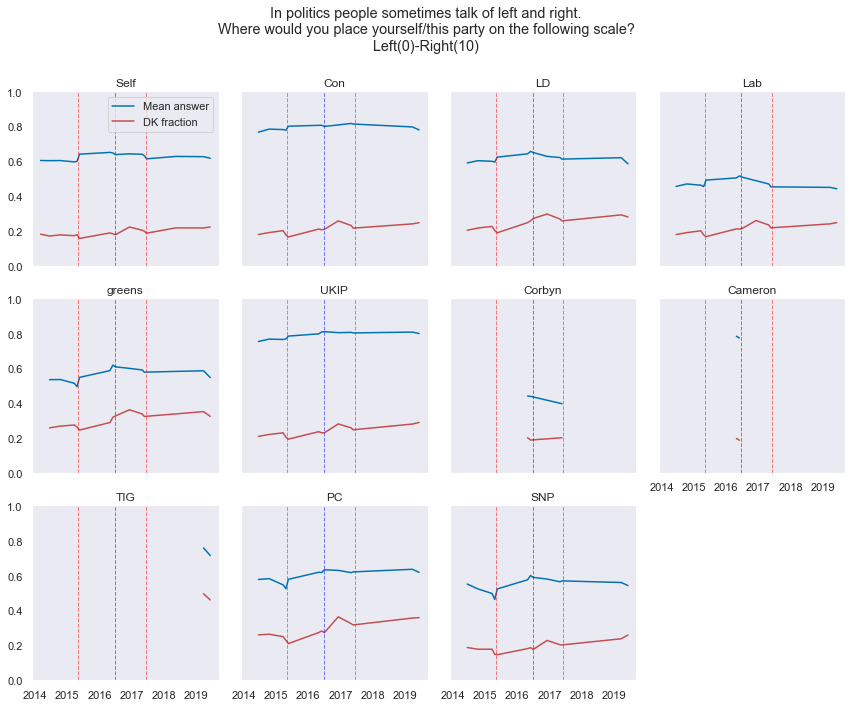

In [22]:
var_name = "lr"
title= "In politics people sometimes talk of left and right.\nWhere would you place yourself/this party on the following scale?\nLeft(0)-Right(10)"
flat_df_num = time_series(var_name,title,col_name="party",dk_nums=[11,-1],dk_str="Don't know",max_y_size=10.0,min_waves_included=2)


g = sns.FacetGrid(data=flat_df_num, col=col_name, col_wrap=4, ylim=(0.0, 1.0), legend_out=False);
g.map(sns.lineplot, "wave",var_name+"_wts", estimator=weighted_mean,ci=None, label="Mean answer",);
g.map(sns.lineplot, "wave","dk", color='r', ci=None, label="DK fraction",);
g.map(plt.axvline, x=pd.to_datetime("7 May 2015"), ls='--', c='red',linewidth=1, alpha=.5)# 2015GE
g.map(plt.axvline, x=pd.to_datetime("23 June 2016"), ls='--', c='blue',linewidth=1, alpha=.5)# 2016EUREF
g.map(plt.axvline, x=pd.to_datetime("8 June 2017"), ls='--', c='red',linewidth=1, alpha=.5)# 2017GE

g.add_legend().set_ylabels("").set_titles(col_template="{col_name}")
g.fig.suptitle(title, y=1.0+0.03*len(title.split("\n")));

treatment = "timeseries"
output_subfolder = create_subdir(BES_output_folder, treatment)
g.savefig(output_subfolder +var_name + ".png",       bbox_inches='tight')


In [25]:
flat_df_num["wave"].value_counts()

2019-06-10    248563
2016-04-28    231690
2017-05-23    225319
2019-03-26    203730
2015-03-22    180012
2015-04-22    177165
2014-06-14    174181
2017-05-01    173005
2015-05-20    172919
2016-12-06    170706
2014-10-14    159891
2016-06-01     45723
2016-07-01     42065
2017-06-19     30332
2018-05-16     30230
2014-03-04     29531
Name: wave, dtype: int64

In [ ]:
var_name = "EUIntegration"

fixed_cats = BES_Panel[var_name+"ConW16"].cat.categories
BES_Panel[match(BES_Panel,var_name+"([a-zA-Z]*)($|W\d+)").index] =\
    BES_Panel[match(BES_Panel,var_name+"([a-zA-Z]*)($|W\d+)").index]\
        .apply(lambda x: x.cat.reorder_categories(fixed_cats))


title= "Some people feel that Britain should do all it can to unite fully with the European Union.\nOther people feel that Britain should do all it can to protect its independence from the European Union.\nWhere would you place yourself and the political parties on this scale?\nUnite fully with the European Union(0)-Protect our independence(10)"
flat_df_num = time_series(var_name,title,col_name="party",dk_nums=[11,-1],dk_str="Don't know",max_y_size=10.0,min_waves_included=2)


g = sns.FacetGrid(data=flat_df_num, col=col_name, col_wrap=4, ylim=(0.0, 1.0), legend_out=False);
g.map(sns.lineplot, "wave",var_name+"_wts", estimator=weighted_mean,ci=None, label="Mean answer",);
g.map(sns.lineplot, "wave","dk", color='r', ci=None, label="DK fraction",);
g.map(plt.axvline, x=pd.to_datetime("7 May 2015"), ls='--', c='red',linewidth=1, alpha=.5)# 2015GE
g.map(plt.axvline, x=pd.to_datetime("23 June 2016"), ls='--', c='blue',linewidth=1, alpha=.5)# 2016EUREF
g.map(plt.axvline, x=pd.to_datetime("8 June 2017"), ls='--', c='red',linewidth=1, alpha=.5)# 2017GE

g.add_legend().set_ylabels("").set_titles(col_template="{col_name}")
g.fig.suptitle(title, y=1.0+0.03*len(title.split("\n")));

treatment = "timeseries"
output_subfolder = create_subdir(BES_output_folder, treatment)
g.savefig(output_subfolder +var_name + ".png", bbox_inches='tight')


In [ ]:
%%time
# var_name = "EUIntegration"

# fixed_cats = BES_Panel[var_name+"ConW16"].cat.categories
# BES_Panel[match(BES_Panel,var_name+"([a-zA-Z]*)($|W\d+)").index] =\
#     BES_Panel[match(BES_Panel,var_name+"([a-zA-Z]*)($|W\d+)").index]\
#         .apply(lambda x: x.cat.reorder_categories(fixed_cats))

subtract_var = "Self"
title= "Some people feel that Britain should do all it can to unite fully with the European Union.\nOther people feel that Britain should do all it can to protect its independence from the European Union.\nWhere would you place yourself and the political parties on this scale?\nUnite fully with the European Union(0)-Protect our independence(10)"
flat_df_num = time_series(var_name,title,subtract_var = subtract_var,col_name="party",dk_nums=[11,-1],dk_str="Don't know",max_y_size=10.0,min_waves_included=2) 

g = sns.FacetGrid(data=flat_df_num, col=col_name, col_wrap=4, ylim=(0.0, 1.0), legend_out=False);
g.map(sns.lineplot, "wave",var_name+"num", ci=None, label="Mean answer",); #n_boot=100
g.map(sns.lineplot, "wave","dk", color='r', ci=None, label="DK fraction",);
g.map(plt.axvline, x=pd.to_datetime("7 May 2015"), ls='--', c='red',linewidth=1, alpha=.5)# 2015GE
g.map(plt.axvline, x=pd.to_datetime("23 June 2016"), ls='--', c='blue',linewidth=1, alpha=.5)# 2016EUREF
g.map(plt.axvline, x=pd.to_datetime("8 June 2017"), ls='--', c='red',linewidth=1, alpha=.5)# 2017GE
if subtract_var:
    g.map(plt.axhline, y=0.5, ls='--', c='green',linewidth=1, alpha=.5)# 2017GE

g.add_legend().set_ylabels("").set_titles(col_template="{col_name}")
g.fig.suptitle(title, y=1.0+0.03*len(title.split("\n")));

treatment = "timeseries"
output_subfolder = create_subdir(BES_output_folder, treatment)
g.savefig(output_subfolder +var_name + ".png", bbox_inches='tight')


In [ ]:
# %%time

# for wave in ["W"+str(x) for x in range(1,17)]:
    
#     BES_Panel["genderedlrMen"+wave] = BES_Panel["lrSelf"+wave].copy()
#     BES_Panel.loc[BES_Panel["gender"]=="Female","genderedlrMen"+wave] = np.nan
#     BES_Panel["genderedlrWomen"+wave] = BES_Panel["lrSelf"+wave].copy()
#     BES_Panel.loc[BES_Panel["gender"]=="Male","genderedlrWomen"+wave] = np.nan

# var_name = "genderedlr"

# subtract_var = False
col_wrap = 2
# title = "In politics people sometimes talk of left and right.\nWhere would you place yourself/this party on the following scale?\nLeft(0)-Right(10)"
# flat_df_num = time_series(var_name,title,subtract_var = subtract_var,col_name="party",dk_nums=[11,-1],dk_str="Don't know",max_y_size=10.0,min_waves_included=2) 

g = sns.FacetGrid(data=flat_df_num, col=col_name, col_wrap=col_wrap, ylim=(0.0, 1.0), legend_out=False, height=6);
g.map(sns.lineplot, "wave",var_name+"num", n_boot=100, label="Mean answer",); #n_boot=100
g.map(sns.lineplot, "wave","dk", color='r', ci=None, label="DK fraction",);
g.map(plt.axvline, x=pd.to_datetime("7 May 2015"), ls='--', c='red',linewidth=1, alpha=.5)# 2015GE
g.map(plt.axvline, x=pd.to_datetime("23 June 2016"), ls='--', c='blue',linewidth=1, alpha=.5)# 2016EUREF
g.map(plt.axvline, x=pd.to_datetime("8 June 2017"), ls='--', c='red',linewidth=1, alpha=.5)# 2017GE
if subtract_var:
    g.map(plt.axhline, y=0.5, ls='--', c='green',linewidth=1, alpha=.5)# 2017GE

g.add_legend().set_ylabels("").set_titles(col_template="{col_name}")
g.fig.suptitle(title, y=1.0+0.03*len(title.split("\n")));

treatment = "timeseries"
output_subfolder = create_subdir(BES_output_folder, treatment)
g.savefig(output_subfolder +var_name + ".png", bbox_inches='tight')


In [ ]:
match(BES_Panel,"lrSelf(Men|Women)"+"([a-zA-Z]*)($|W\d+)")

In [ ]:
var_name = "EUIntegration"
np.unique([x.split("W")[0] for x in match(BES_Panel,var_name+"([a-zA-Z]*)($|W\d+)",case_sensitive=True).index])

In [ ]:
BES_Panel["eesEUIntegrationConW1"]

In [ ]:
BES_Panel["EUIntegrationConW9"]

In [ ]:
%config InlineBackend.figure_format = "png"
# %%time
# plt.rcParams["axes.grid"] = True
title= "Government should try to make incomes equal(0/10)\nGovernment should be less concerned about equal incomes(10/10)"

g = sns.FacetGrid(data=flat_df_num, col=col_name, col_wrap=4, ylim=(0.0, 1.0), legend_out=False);
g.map(sns.lineplot, "wave","dk", color='r', ci=None, label="DK fraction",);
g.map(sns.lineplot, "wave",var_name+"_wts", estimator=weighted_mean,ci=None, label="Mean answer",);

g.add_legend().set_ylabels("").set_titles(col_template="{col_name}")
g.fig.suptitle(title, y=1.05);

In [ ]:
%config InlineBackend.figure_format = "png"
# %%time
# plt.rcParams["axes.grid"] = True
title= "Government should try to make incomes equal(0/10)\nGovernment should be less concerned about equal incomes(10/10)"

from datetime import datetime
flat_df_num["wave"] = flat_df_num["wave"].apply(lambda x: datetime.timestamp(x))

g = sns.FacetGrid(data=flat_df_num, col=col_name, col_wrap=4, ylim=(0.0, 1.0), legend_out=False);
g.map(sns.regplot, "wave","dk", color='r', ci=None, label="DK fraction",);
g.map(sns.regplot, "wave",var_name+"num", label="Mean answer",);
# estimator=weighted_mean,ci=None,
g.add_legend().set_ylabels("").set_titles(col_template="{col_name}")
g.fig.suptitle(title, y=1.05);

In [ ]:
# wave_to_date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"][["Wave No","Date_Start"]].set_index("Wave No")["Date_Start"]
# wave_to_date
# pd.to_datetime(wave_to_date, format="%b-%y")

In [ ]:
# BES_Panel["redistConW16"].value_counts()/BES_Panel["redistConW16"].value_counts().sum()

In [ ]:
# g = sns.FacetGrid(data=flat_df_num, col=col_name, col_wrap=3);
# g.map(sns.lineplot, "wave",var_name+"_wts", estimator=weighted_mean,ci=None);

In [26]:
20/45

0.4444444444444444

In [ ]:
flat_df_num

In [ ]:
%%time

g = sns.FacetGrid(data=flat_df_num, col=col_name, col_wrap=3);
g.map(sns.lineplot, "wave",var_name+"_wts", estimator=weighted_mean,n_boot=20);
g.map(sns.lineplot, "wave","dk", color='r');

In [ ]:
%%time

g = sns.FacetGrid(data=flat_df_num.sample(replace=True,weights="wt",axis=0,frac=1),
                  col="subject", col_wrap=3);
g.map(sns.lineplot, "wave","redist_num", ci=90);